In [1]:
%matplotlib inline
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
from matplotlib import pyplot as plt
import pyshtools

Loading SHTOOLS documentation


In [4]:
coeffs,errors,lmax = pyshtools.SHReadError('EGM2008_to2190_TideFree',2190)

In [3]:
# Setting this next coefficient to 1 gives the so-called "external" gravitational potential
# Setting it to zero gives the "disturbing" potential. 
coeffs[0,0,0] = 1.

OK. Visualizing the field, we see that it is utterly dominated by the centrifugal accelerations due to the rotating planet. This is what geophysicists usually get rid of via the "Latitude Correction" because it is essentially uninteresting for identifying the mass distributions. Physical geodesists, on the other hand, care a great deal about this because their primary interest is in determining the shape of the planet.

There are smaller longitudinal effects, due to the ellipsoidal (as opposed to spheroidal) shape of the Earth, but let's see how far we get by simply setting the (co)latitudinal coefficient to zero -- i.e. $C_{20}$ in the SH expansion.

This is probably way too crude for publication. We really should compute the latitude correction, and subtract that from the SH expansion. However, once we get to the _filtering_ part of filtered backprojection, it is very unlikely to matter.

In [7]:
#Keep it around for future reference/use...
C20 = coeffs[0,2,0]
print C20
coeffs[0,2,0] = 0.

-0.000484165143791


In [8]:
grid    = pyshtools.MakeGridDH(coeffs,sampling=2,csphase=1)

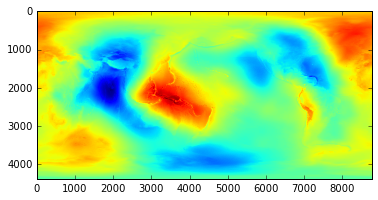

In [9]:
plt.imshow(grid)

In [7]:
grav = pyshtools.MakeGravGridDH(coeffs,pyshtools.constant.gm_earth,pyshtools.constant.r0_pot_earth)

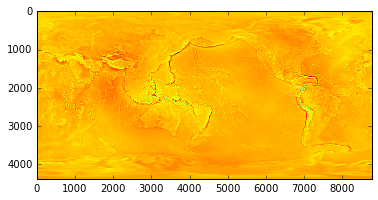

In [9]:
plt.imshow(grav[0])



**Old dead code only below here. Mostly preserved for examples of calling routines...**

In [ ]:
coeffs = pyshtools.SHCoeffs.from_file('EGM2008_to2190_TideFree',2190)

In [8]:
pyshtools.MakeGridDH?